### **TransLOB** 
This is the implementation of the model TransLOB proposed in the paper *Transformers for limit order books by james wallbridge*

In [46]:
# load packages

import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from google.colab import drive
import torch
from tqdm import tqdm
from torch.utils import data
import torch.nn as nn
import torch.optim as optim
from keras import layers
from keras.layers import Conv1D, BatchNormalization
import tensorflow as tf

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### **Data**
The dataset in the folder Dataset is the LOBSTER dataset zipped and normalized. I have combined the data of the 5 stocks available for free. I used the version with 10 levels, so we have 40 columns, in fact for every level we have a quadruple wiht the ask and bid prices and with the volumes associated, for more information i reference to the thesis.

I used 70% to do the training, 15% to do the validation and 15% for the testing.

In [27]:
#Initially we download the zipped data

import os 
if not os.path.isfile('data.zip'):
    !wget https://github.com/LeonardoBerti07/Deep-Learning-Algorithms-for-financial-time-serie-modeling-/blob/main/Dataset/data.zip
    print('data downloaded.')
else:
    print('data already existed.')

--2022-11-19 17:17:01--  https://github.com/LeonardoBerti07/Deep-Learning-Algorithms-for-financial-time-serie-modeling-/blob/main/Dataset/data.zip
Resolving github.com (github.com)... 20.27.177.113
Connecting to github.com (github.com)|20.27.177.113|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://github.com/LeonardoBerti07/Deep-Learning-Algorithms-for-financial-time-serie-forecasting-/blob/main/Dataset/data.zip [following]
--2022-11-19 17:17:02--  https://github.com/LeonardoBerti07/Deep-Learning-Algorithms-for-financial-time-serie-forecasting-/blob/main/Dataset/data.zip
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘data.zip’

data.zip                [  <=>               ] 140.85K   294KB/s    in 0.5s    

2022-11-19 17:17:03 (294 KB/s) - ‘data.zip’ saved [144227]

data downloaded.


In [28]:
# please change the data_path to your local path and unzip the file

data_path =  "/content/drive/MyDrive/Data2/DB4_norm.npy"
dec = np.load(data_path)

print(dec.shape)
train_size = int(0.70 * dec.shape[0])
val_size = int(0.15 * dec.shape[0])

dec_train = dec[:train_size]
dec_val = dec[train_size:val_size+train_size]
dec_test = dec[val_size+train_size:]

(922925, 40)


In [29]:
def labeling(X, T):

  [N, D] = X.shape
  print(N)
  Y = np.zeros((X.shape[0] - 2*T + 1))
  alpha = 0.00072
  media = []
  for i in range(0, X.shape[0]- 2*T + 1):
    ask_minus = X[i:i+T, :1]
    bid_minus = X[i:i+T, 2:3]
    ask_plus = X[i+T:i+2*T, :1]
    bid_plus = X[i+T:i+2*T, 2:3]
    m_minus = (ask_minus + bid_minus) / 2
    m_minus = np.sum(m_minus) / T
    m_plus = (ask_plus + bid_plus) / 2
    m_plus = np.sum(m_plus) / T
    media.append((m_plus - m_minus) / m_minus)
    if (m_plus - m_minus) / m_minus < -alpha:
      label = 1
    elif (m_plus - m_minus) / m_minus > alpha:
      label = 0
    else:
      label = 2
    Y[i] = label
  
  plt.hist(Y)
  plt.show()

  return Y

138438


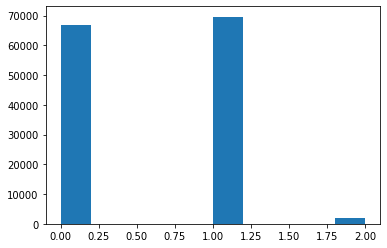

138440


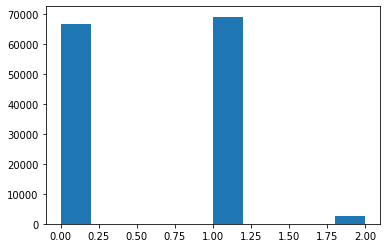

646047


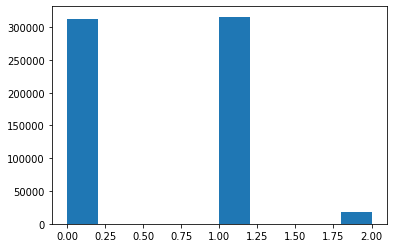

In [30]:
#Create the dataset

class Dataset(data.Dataset):
    """Characterizes a dataset for PyTorch"""
    def __init__(self, x, y, num_classes, T):
        """Initialization""" 
        self.num_classes = num_classes
        self.T = T
        self.x = x   
        self.y = y
       
        self.length = x.shape[0] - 2*T + 1

        x = torch.from_numpy(x)
        self.x = torch.unsqueeze(x, 1)
        self.y = torch.from_numpy(y)

    def __len__(self):
        """Denotes the total number of samples"""
        return self.length

    def __getitem__(self, i):
        input = self.x[i:i+self.T, :]
        input = input.permute(1, 0, 2)
        #print(input.shape)
        return input, self.y[i]

batch_size = 32
epochs = 50
T = 50
lr = 0.0001

y_val = labeling(dec_val, T)
y_test = labeling(dec_test, T)
y_train = labeling(dec_train, T)

dataset_val = Dataset(dec_val, y_val, num_classes=3, T=50)
dataset_test = Dataset(dec_test, y_test, num_classes=3, T=50)
dataset_train = Dataset(dec_train, y_train, num_classes=3, T=50)

train_loader = torch.utils.data.DataLoader(dataset=dataset_train, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset=dataset_val, batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(dataset=dataset_test, batch_size=batch_size, shuffle=False)



### **Model Architecture**
The model architecture is specified in the original paper.

In [31]:
def lob_dilated(x):
  """
  TransLOB dilated 1-D convolution module
  """

  x = layers.Conv1D(filters=14,kernel_size=2,strides=1,activation='relu',padding='causal')(x)  
  x = layers.Conv1D(14,kernel_size=2,dilation_rate=2,activation='relu',padding='causal')(x)
  x = layers.Conv1D(14,kernel_size=2,dilation_rate=4,activation='relu',padding='causal')(x)
  x = layers.Conv1D(14,kernel_size=2,dilation_rate=8,activation='relu',padding='causal')(x)
  y = layers.Conv1D(14,kernel_size=2,dilation_rate=16,activation='relu',padding='causal')(x)
  y = layers.BatchNormalization()(y)

  return y

In [32]:
def positional_encoding(x):
  steps, d_model = x.get_shape().as_list()[-2:] 
  ps = np.zeros([steps,1],dtype=K.floatx()) 
  for tx in range(steps):
    ps[tx,:] = [(2/(steps-1))*tx - 1] 

  ps_expand = K.expand_dims(K.constant(ps),axis=0) 
  ps_tiled = K.tile(ps_expand,[K.shape(x)[0],1,1]) 
  ps_tiled = tf.reshape(ps_tiled, (x.shape[0], x.shape[1], x.shape[2], ps_tiled.shape[2]))
  x = K.concatenate([x,ps_tiled],axis=-1)
  return x

In [50]:
class transformer(nn.Module):
    def __init__(self, y_len):
        super().__init__()
        self.y_len = y_len

        self.transformer = nn.Transformer(d_model=750, nhead=3, 
                                            num_encoder_layers=2, num_decoder_layers=2, 
                                            dim_feedforward=3000, dropout=0.0, norm_first=True,
                                            batch_first=True, device=device)
        self.norm = nn.BatchNorm1d(750)
        self.norm3 = nn.BatchNorm1d(700)
        self.norm2 = nn.BatchNorm1d(512)
        
        self.dropout = nn.Dropout(0.1)

        self.fc1 = nn.Linear(750, 512)
        self.fc2 = nn.Linear(512, 512)
        self.fc3 = nn.Linear(512, 3)

        self.activation = nn.LeakyReLU(negative_slope=0.01)

    def forward(self, x):
        np_tensor = x.cpu().numpy()
        tf_tensor = tf.convert_to_tensor(np_tensor)

        x = lob_dilated(tf_tensor)          

        x = positional_encoding(x)

        np_tensor = x.cpu().numpy()
        x = torch.tensor(np_tensor).to(device)

        x = self.norm(self.transformer(x))

        x = torch.reshape(x, (x.shape[0], x.shape[1]*x.shape[2]*x.shape[3]))

        x = self.dropout(self.norm2(self.activation(self.fc1(x))))
        x = self.dropout(self.norm2(self.activation(self.fc2(x))))
        x = self.fc3(x)
        forecast_y = torch.softmax(x, dim=1)
        
        return forecast_y

### **Model Training**

In [51]:
model = transformer(y_len = dataset_train.num_classes)
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr)

def batch_gd(model, criterion, optimizer, train_loader, test_loader, epochs):
    
    train_losses = np.zeros(epochs)
    test_losses = np.zeros(epochs)
    best_test_loss = np.inf
    best_test_epoch = 0

    for it in tqdm(range(epochs)):
        
        model.train()
        t0 = datetime.now()
        train_loss = []
        for inputs, targets in train_loader:
            # move data to GPU
            inputs, targets = inputs.to(device, dtype=torch.float), targets.to(device, dtype=torch.int64)
            # print("inputs.shape:", inputs.shape)
            # zero the parameter gradients
            optimizer.zero_grad()
            # Forward pass
            # print("about to get model output")
            outputs = model(inputs)
            # print("done getting model output")
            # print("outputs.shape:", outputs.shape, "targets.shape:", targets.shape)
            loss = criterion(outputs, targets)
            # Backward and optimize
            # print("about to optimize")
            loss.backward()
            optimizer.step()
            train_loss.append(loss.item())
        # Get train loss and test loss
        train_loss = np.mean(train_loss) # a little misleading
    
        model.eval()
        test_loss = []
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device, dtype=torch.float), targets.to(device, dtype=torch.int64)      
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            test_loss.append(loss.item())
        test_loss = np.mean(test_loss)

        # Save losses
        train_losses[it] = train_loss
        test_losses[it] = test_loss
        
        if test_loss < best_test_loss:
            torch.save(model, '/content/drive/MyDrive/Output/best_model_transformer')
            best_test_loss = test_loss
            best_test_epoch = it
            print('model saved')

        dt = datetime.now() - t0
        print(f'Epoch {it+1}/{epochs}, Train Loss: {train_loss:.4f}, \
          Validation Loss: {test_loss:.4f}, Duration: {dt}, Best Val Epoch: {best_test_epoch}')

    return train_losses, test_losses

In [ ]:
train_losses, val_losses = batch_gd(model, criterion, optimizer, 
                                    train_loader, val_loader, epochs)

### **Model Testing**

In [ ]:
model = torch.load('/content/drive/MyDrive/Output/best_model_transformer')

n_correct = 0.
n_total = 0.
all_targets = []
all_predictions = []

for inputs, targets in test_loader:
    # Move to GPU
    inputs, targets = inputs.to(device, dtype=torch.float), targets.to(device, dtype=torch.int64)

    # Forward pass
    outputs = model(inputs)
    
    # Get prediction
    # torch.max returns both max and argmax
    _, predictions = torch.max(outputs, 1)

    # update counts
    n_correct += (predictions == targets).sum().item()
    n_total += targets.shape[0]

    all_targets.append(targets.cpu().numpy())
    all_predictions.append(predictions.cpu().numpy())

test_acc = n_correct / n_total
print(f"Test acc: {test_acc:.4f}")

all_targets = np.concatenate(all_targets)    
all_predictions = np.concatenate(all_predictions)   
print('accuracy_score:', accuracy_score(all_targets, all_predictions))
print(classification_report(all_targets, all_predictions, digits=4)) 
print(confusion_matrix(all_targets, all_prediction, normalize=True))